In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
import pocomc as pc

In [3]:
# Get haslam map and use it to generate sky temperature cube in 10-100 MHz
def map_remazeilles_408MHz(map_file, galactic_coord_file):

    '''

    This function will return the Haslam map reprocessd by Remazeilles et al. (2014) in NESTED Galactic Coordinates. But the input data is in RING coordinates.

    This version is only destriped, not desourced.

    Example of input data:
    ----------------------
    map_file            = edges_folder + '/sky_models/haslam_map/haslam408_ds_Remazeilles2014.fits'
    galactic_coord_file = edges_folder + '/sky_models/coordinate_maps/pixel_coords_map_ring_galactic_res9.fits'


    '''


    # Loading NESTED galactic coordinates
    # -----------------------------------
    coord              = fits.open(galactic_coord_file)
    coord_array        = coord[1].data
    lon_ring           = coord_array['LONGITUDE']
    lat_ring           = coord_array['LATITUDE']

    lon = hp.reorder(lon_ring, r2n=True)
    lat = hp.reorder(lat_ring, r2n=True)
 

    # GALAC_COORD_object = apc.SkyCoord(lon, lat, frame='galactic', unit='deg')  # defaults to ICRS frame



    # Loading Haslam map
    # ------------------
    haslam_map = fits.open(map_file)
    x  = (haslam_map[1].data)['temperature']
    haslam408_ring = x.flatten()

    haslam408 = hp.reorder(haslam408_ring, r2n=True)


    print('REMAZEILLES 408MHz MAP')


    return haslam408, lon, lat

map_file = "haslam408_ds_Remazeilles2014.fits"
galactic_coord_file = "pixel_coords_map_ring_galactic_res9.fits"
hl, long, lat = map_remazeilles_408MHz(map_file,galactic_coord_file)

nu = np.arange(10,101,1)
real_map = np.array([hl*(10/408)**(-2.5)])
for i in np.arange(11,101,1):
    real_map = np.vstack([real_map,hl*(i/408)**(-2.5)])


REMAZEILLES 408MHz MAP


In [15]:
pmlong = long
for i in range(len(long)):
    if long[i] <= 360 and long[i] >= 180:
        pmlong[i] = long[i] - 360

In [7]:
# Generate 2D Gaussian Beam Cube plane
freq = np.array(range(10,101))
x0 = 0
y0 = 0
slope = 0.3
intercept = 7.5
sigx = slope * freq + intercept
sigy = sigx

In [10]:
# Convolution to generate curve
def convolution(slope, intercept, sky):
    x = np.ones(91)
    for i in range(91):
        sig = slope * freq + intercept
        lat_ = np.exp(-(lat**2/(2*(sig[i]**2))))
        long_ = np.exp((-long**2/(2*sig[i]**2)))
        bc = lat_*long_* 5
        x[i] = np.sum(bc*sky[i])/np.sum(bc)
    return x
curve = convolution(slope, intercept, real_map)

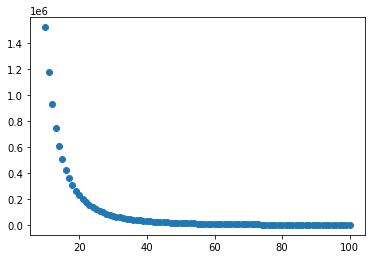

In [11]:
plt.scatter(freq,curve)

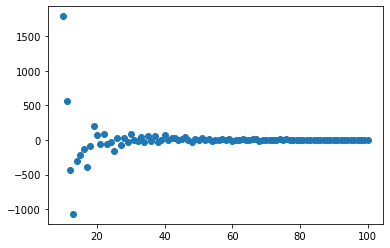

In [55]:
# Add Gaussian error to the curve
dt = 1
dnu = 1e6
sigma = curve/np.sqrt(dnu*dt)
data = np.random.normal(curve, sigma) 
noise = data - curve
plt.scatter(freq,noise)

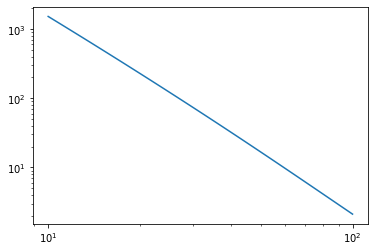

In [56]:
#Sigma
plt.loglog(freq,sigma)

In [57]:
# Define model to simulate data
def model(paras, nu):
    slope,intercept = paras
    return convolution(slope, intercept, real_map)

In [58]:
# Define log-likelihood function, log-prior function, and boundary
def log_like(params, nu, data, sigma):
    m = model(params, nu)
    diff = m - data
    return -0.5 * np.sum((diff/sigma)**2)
def log_prior(params, bounds):
    if np.any(params < bounds.T[0]) or np.any(params > bounds.T[1]):
        return -np.inf
    else:
        return 0.0
bounds = np.array([[0.0, 1.0], # slope
                 [5.0,10.0]]) # intercept

In [59]:
n_particles = 4
n_dim = 2
prior_samples = np.random.uniform(low = bounds.T[0], high= bounds.T[1], size=(n_particles, n_dim))

In [22]:
# Sampler initialisation
sampler = pc.Sampler(n_particles,
                     n_dim,
                     log_likelihood=log_like,
                     log_prior=log_prior,
                     bounds=bounds,
                     log_likelihood_args=[nu, data, sigma],
                     log_prior_args=[bounds]
                    )

# Run sampler
sampler.run(prior_samples)

Iter: 46it [1:09:55, 91.21s/it, beta=1, calls=1040, ESS=0.986, logZ=-74.3, accept=0.516, N=7, scale=1.65, corr=0.314]         


In [27]:
# Add extra samples
sampler.add_samples(250)
results = sampler.results

Iter: 63it [52:07, 49.64s/it, beta=1, calls=tensor(2432), ESS=0.95, logZ=-74.3, accept=0.413, N=2, scale=1.72, corr=0.437]   


In [28]:
results = sampler.results

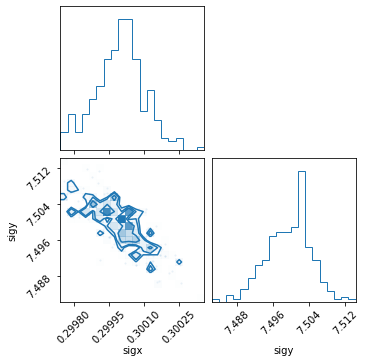

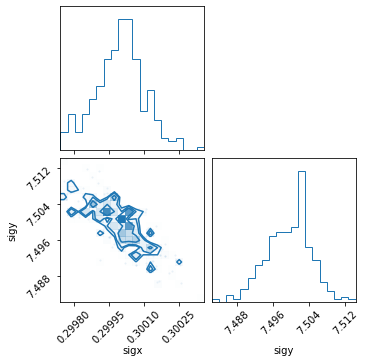

In [29]:
pc.plotting.corner(results, labels=['sigx', 'sigy'])

In [30]:
print('Mean values = ', np.mean(results['samples'], axis=0, dtype = "float64"))
print('Standard deviation values = ', np.std(results['samples'], axis=0,dtype = "float64"))

Mean values =  [0.29999404 7.49942691]
Standard deviation values =  [0.00010528 0.0049141 ]


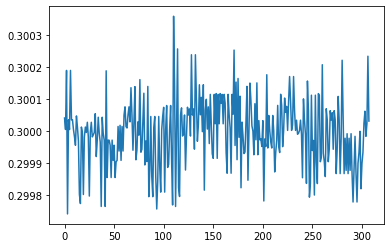

In [31]:
plt.plot(results['samples'][:,0])

In [90]:
real_map.shape

(91, 3145728)

# Lower Resolution Code

In [11]:
reduce_map = hp.pixelfunc.ud_grade(real_map, 2**8, order_in = 'NESTED', order_out = 'NESTED')

In [5]:
hp.pixelfunc.ud_grade?

In [6]:
reduce_map_hl = hp.pixelfunc.ud_grade(hl, 2**8, order_in = 'NESTED', order_out = 'NESTED')

In [7]:
reduced_map2 = np.array([reduce_map_hl*(10/408)**(-2.5)])
for i in np.arange(11,101,1):
    reduced_map2 = np.vstack([reduced_map2,reduce_map_hl*(i/408)**(-2.5)])

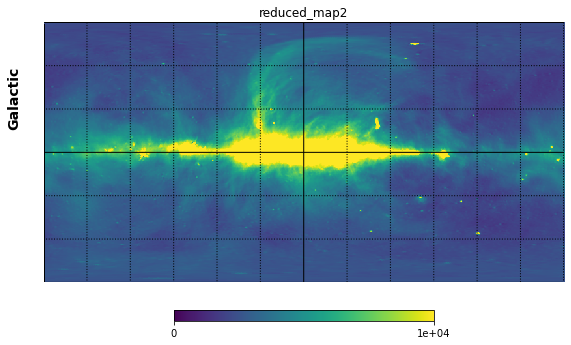

In [8]:
# At 50Mhz, the sky temperature map
hp.cartview(reduced_map2[49], 
           nest=True,
           min=0,
    max=1e4, coord=["G", "G"],
           title = "reduced_map2")
hp.graticule()

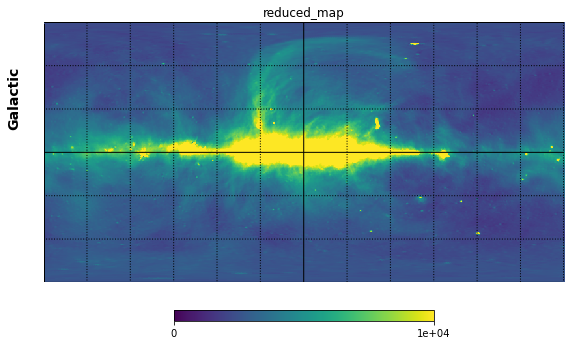

In [12]:
# At 50Mhz, the sky temperature map
hp.cartview(reduce_map[49], 
           nest=True,
           min=0,
    max=1e4, coord=["G", "G"],
           title = "reduced_map")
hp.graticule()

In [123]:
real_map.shape, reduce_map.shape

((91, 3145728), (91, 786432))

In [124]:
3145728/786432

4.0

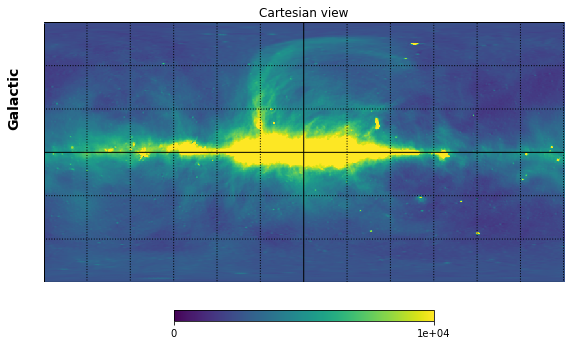

In [4]:
# At 60Mhz, the sky temperature map
hp.cartview(real_map[49], 
           nest=True,
           min=0,
    max=1e4, coord=["G", "G"])
hp.graticule()

In [9]:
reduce_long = hp.pixelfunc.ud_grade(long, 2**8, order_in = 'NESTED', order_out = 'NESTED')
reduce_lat = hp.pixelfunc.ud_grade(lat, 2**8, order_in = 'NESTED', order_out = 'NESTED')

In [13]:
reduce_map.shape

(91, 786432)

In [14]:
# Convolution to generate curve
def reduce_convolution(slope, intercept, sky):
    x = np.ones(91)
    for i in range(91):
        sig = slope * freq + intercept
        lat_ = np.exp(-(reduce_lat**2/(2*(sig[i]**2))))
        long_ = np.exp((-reduce_long**2/(2*sig[i]**2)))
        bc = lat_*long_* 5
        x[i] = np.sum(bc*sky[i])/np.sum(bc)
    return x
curve2 = reduce_convolution(slope,intercept,reduce_map)

NameError: name 'slope' is not defined

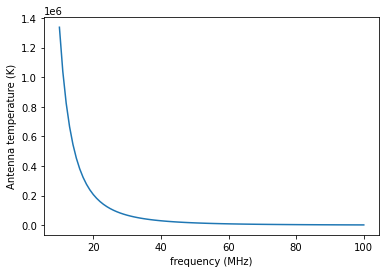

In [65]:
plt.xlabel("frequency (MHz)")
plt.ylabel("Antenna temperature (K)")
plt.plot(freq,curve2)

Text(0, 0.5, 'σ_n (K)')

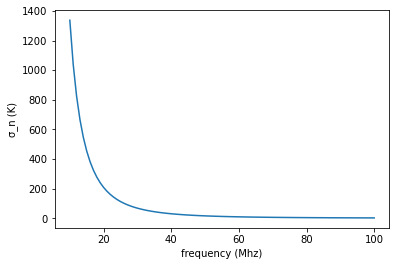

In [99]:
# Add Gaussian error to the curve
dt = 1
dnu = 1e6
sigma2 = curve2/np.sqrt(dnu*dt)
data2 = np.random.normal(curve2, sigma2) 
noise2 = data2 - curve2
plt.plot(freq,sigma2)
plt.xlabel("frequency (Mhz)")
plt.ylabel("σ_n (K)")

In [52]:
# Define model to simulate data
def model2(paras, nu):
    slope,intercept = paras
    return reduce_convolution(slope, intercept, reduce_map)

In [16]:
# Define log-likelihood function, log-prior function, and boundary
def log_like2(params, nu, data, sigma):
    m = model2(params, nu)
    diff = m - data
    return -0.5 * np.sum((diff/sigma)**2)
def log_prior(params, bounds):
    if np.any(params < bounds.T[0]) or np.any(params > bounds.T[1]):
        return -np.inf
    else:
        return 0.0
bounds = np.array([[0.0, 1.0], # slope
                 [5.0,10.0]]) # intercept

In [17]:
n_particles = 4
n_dim = 2
prior_samples = np.random.uniform(low = bounds.T[0], high= bounds.T[1], size=(n_particles, n_dim))

In [18]:
# Sampler initialisation
sampler = pc.Sampler(n_particles,
                     n_dim,
                     log_likelihood=log_like2,
                     log_prior=log_prior,
                     bounds=bounds,
                     log_likelihood_args=[nu, data2, sigma2],
                     log_prior_args=[bounds]
                    )

# Run sampler
sampler.run(prior_samples)

Iter: 40it [07:43, 11.59s/it, beta=1, calls=704, ESS=0.951, logZ=-57, accept=0.514, N=1, scale=1.45, corr=0.656]             


In [46]:
# Add extra samples
sampler.add_samples(500)
results = sampler.results

Iter: 125it [1:40:20, 48.16s/it, beta=1, calls=tensor(31904), ESS=0.95, logZ=-57, accept=0.161, N=7, scale=2.78, corr=0.599]    


In [47]:
results = sampler.results
print('Mean values = ', np.mean(results['samples'], axis=0, dtype = "float64"))
print('Standard deviation values = ', np.std(results['samples'], axis=0,dtype = "float64"))

Mean values =  [0.30033322 7.48295737]
Standard deviation values =  [0.00014881 0.00674163]


In [43]:
log_like2([0.3,7.5],freq,data2,sigma2)

-44.09577030157661

In [44]:
log_like2([0.30032132, 7.48332701],freq,data2,sigma2)

-41.105678769655796

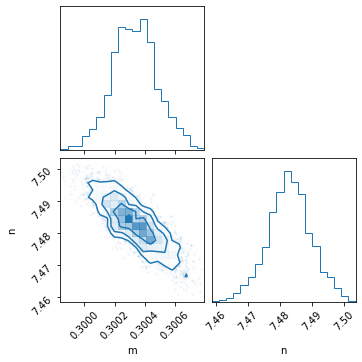

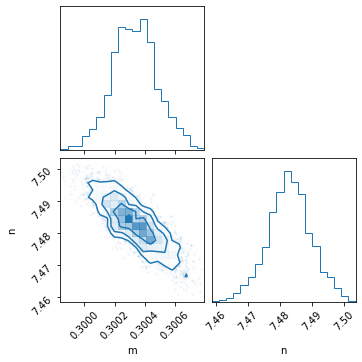

In [98]:
pc.plotting.corner(results, labels=['m', 'n'])

In [67]:
results

{'samples': array([[0.30038387, 7.4814167 ],
        [0.30040786, 7.4713964 ],
        [0.3004213 , 7.478416  ],
        ...,
        [0.30048725, 7.4804144 ],
        [0.3002172 , 7.4897413 ],
        [0.3001637 , 7.4884996 ]], dtype=float32),
 'loglikelihood': array([-41.146824, -43.807816, -41.270767, ..., -42.00887 , -41.603664,
        -41.795265], dtype=float32),
 'logprior': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'logz': array([  0.        ,  -0.47838827,  -0.75251479,  -1.35665739,
         -1.8480922 ,  -2.14923132,  -2.29214084,  -2.53242695,
         -3.38711612,  -3.95815067,  -4.85873733,  -5.56552694,
         -6.24546764,  -6.71694991,  -7.11318472,  -7.79245188,
         -8.58326252,  -9.00563486,  -9.32645781,  -9.90937466,
        -10.15310449, -10.39658588, -10.71883446, -11.94498133,
        -12.23865746, -12.45253955, -12.80997942, -13.1977025 ,
        -13.63617918, -13.97320327, -14.43492755, -14.75972649,
        -14.98333688, -16.02482725, -17.22

In [72]:
print("logZ estimated using PMC : ", np.round(sampler.results["logz"][-1],3))

logZ estimated using PMC :  -56.96


In [84]:
sampler.results["logz"]

array([  0.        ,  -0.47838827,  -0.75251479,  -1.35665739,
        -1.8480922 ,  -2.14923132,  -2.29214084,  -2.53242695,
        -3.38711612,  -3.95815067,  -4.85873733,  -5.56552694,
        -6.24546764,  -6.71694991,  -7.11318472,  -7.79245188,
        -8.58326252,  -9.00563486,  -9.32645781,  -9.90937466,
       -10.15310449, -10.39658588, -10.71883446, -11.94498133,
       -12.23865746, -12.45253955, -12.80997942, -13.1977025 ,
       -13.63617918, -13.97320327, -14.43492755, -14.75972649,
       -14.98333688, -16.02482725, -17.22116722, -17.97837377,
       -19.04782665, -20.91890049, -27.30569219, -33.49507617,
       -56.9595661 ])

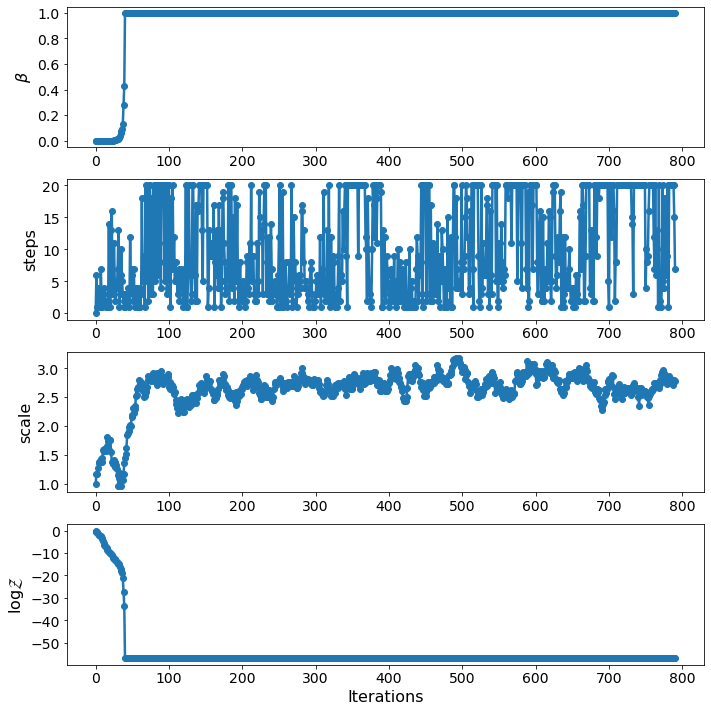

In [89]:
import matplotlib.pyplot as plt

pc.plotting.run(results)
plt.show()